In [12]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
from typing import List

def get_performance(report):
    loadgen_data = report['loadgen_data']

    total_request_count = len(loadgen_data)
    no_response_count = 0
    error_count = 0
    requests : List[RequestData] = []
    for request_data in loadgen_data:
        if 'error' not in request_data.keys():
            request = RequestData.init_from_dict(request_data)
            requests.append(request)
            continue

        if request_data == {'error': 'No response!'}:
            no_response_count += 1
        else:
            error_count += 1

    ttft_attain_count = 0
    tbt_attain_count = 0
    total_attain_count = 0
    for request in requests:
        ttft_attain, tbt_attain = request.satisfy_SLO()
        if ttft_attain:
            ttft_attain_count += 1
        
        if tbt_attain:
            tbt_attain_count += 1
        
        if ttft_attain and tbt_attain:
            total_attain_count += 1

    ttft_attain_rate = ttft_attain_count / total_request_count
    tbt_attain_rate = tbt_attain_count / total_request_count
    total_attain_rate = total_attain_count / total_request_count

    # print(f"Among {total_request_count} requests, {ttft_attain_count} attain TTFT, {tbt_attain_count} attain TBT, {total_attain_count} attain total")
    # print(f"total attain rate: {total_attain_rate*100:.1f}%, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%")
    return ttft_attain_rate, tbt_attain_rate, total_attain_rate

from collections import defaultdict

def get_slo_violation_rate_vs_time(report, window_size=1.0):
    loadgen_data = report['loadgen_data']
    requests = []

    # Filter valid requests
    for request_data in loadgen_data:
        if 'error' not in request_data:
            request = RequestData.init_from_dict(request_data)
            requests.append(request)

    if not requests:
        return [], []

    # Use the first arrival_time as the base
    start_str = report.get('router_start_time', 'N/A')
    tz_sg = ZoneInfo("Asia/Singapore")
    router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
    base_time = router_start_time
    window_buckets = defaultdict(int)

    for request in requests:
        offset = request.arrival_time - base_time
        window_index = int(offset // window_size)

        ttft_attain, tbt_attain = request.satisfy_SLO()
        if not (ttft_attain and tbt_attain):
            window_buckets[window_index] += 1

    # Sort and convert to lists
    sorted_windows = sorted(window_buckets.keys())
    time_offsets = [i * window_size for i in sorted_windows]
    violation_counts = [window_buckets[i] for i in sorted_windows]

    return time_offsets, violation_counts

def get_cumulative_slo_violations_vs_time(report, window_size=1.0):
    loadgen_data = report['loadgen_data']
    requests = []

    # Filter valid requests
    for request_data in loadgen_data:
        if 'error' not in request_data:
            request = RequestData.init_from_dict(request_data)
            requests.append(request)

    if not requests:
        return [], []

    # Use the earliest arrival_time as the base
    start_str = report.get('router_start_time', 'N/A')
    tz_sg = ZoneInfo("Asia/Singapore")
    router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
    base_time = router_start_time
    window_buckets = defaultdict(int)

    for request in requests:
        offset = request.arrival_time - base_time
        window_index = int(offset // window_size)

        ttft_attain, tbt_attain = request.satisfy_SLO()
        if not (ttft_attain and tbt_attain):
            window_buckets[window_index] += 1

    # Sort and accumulate violation count over time
    sorted_windows = sorted(window_buckets.keys())
    time_offsets = []
    cumulative_violations = []

    total_violations = 0
    for i in sorted_windows:
        total_violations += window_buckets[i]
        time_offsets.append(i * window_size)
        cumulative_violations.append(total_violations)

    return time_offsets, cumulative_violations

QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_2, TTFT attain rate: 35.2%, TBT attain rate: 99.6%, total attain rate: 35.2%
QUERY_PROM is 0, skipping Prometheus startup.
Running Python app...
query_metrics_list: []
params_list: []
For run_log_dir: /mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_3, TTFT attain rate: 53.1%, TBT attain rate: 99.1%, total attain rate: 53.1%


(100.0, 500.0)

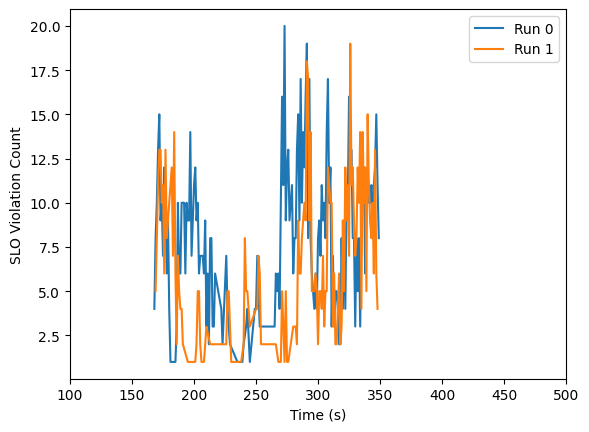

In [14]:
import matplotlib.pyplot as plt
run_log_dirs = [
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_2",
    "/mnt/network_drive/lrq/logs/logs_2025-07-28-14-30-39/run_3",
]

ttft_attain_rates = []
tbt_attain_rates = []
total_attain_rates = []

for i, run_log_dir in enumerate(run_log_dirs):
    GRAN = "30s"
    metrics_list = []
    report_file_path = analyze_data(run_log_dir, metrics_list)
    with open(report_file_path, 'r') as f:
        report = json.load(f)

    ttft_attain_rate, tbt_attain_rate, total_attain_rate = get_performance(report)
    time_offsets, violation_counts = get_slo_violation_rate_vs_time(report)
    # time_offsets, violation_counts = get_cumulative_slo_violations_vs_time(report)

    print(f"For run_log_dir: {run_log_dir}, TTFT attain rate: {ttft_attain_rate*100:.1f}%, TBT attain rate: {tbt_attain_rate*100:.1f}%, total attain rate: {total_attain_rate*100:.1f}%")

    ttft_attain_rates.append(ttft_attain_rate*100)
    tbt_attain_rates.append(tbt_attain_rate*100)
    total_attain_rates.append(total_attain_rate*100)
    # plt.figure(figsize=(10, 5))
    plt.plot(time_offsets, violation_counts, label=f"Run {i}")

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("SLO Violation Count")
plt.xlim([100, 500])